# Environment Setup

We will require a Conda environment in order to import the `ViennaRNA` library created by [Lorenz et al. (2011)](https://doi.org/10.1186/1748-7188-6-26).

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:24
🔁 Restarting kernel...


With the Conda environment now installed, we can install the `ViennaRNA` library.

**NOTE**: Colab will crash after this install. Run the subsequent cells manually by clicking an appropriate option under the **Runtime** menu.

In [2]:
!conda install -c bioconda viennarna

Solving environment: \ | / - \ | / - \ | / - \ | / - done


==> WARNING: A newer version of conda exists. <==
  current version: 23.1.0
  latest version: 23.5.0

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.5.0



## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - viennarna


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.5.7   |       hbcca054_0         145 KB  conda-forge
    certifi-2023.5.7           |     pyhd8ed1ab_0         149 KB  conda-forge
    openssl-3.1.1              |       hd590300_1         2.5 MB  conda-forge
    perl-5.32.1                | 2_h7f98852_perl5        14.4 MB  conda-forge
    viennarna-2.6.2            |py310pl5321h6cc9453_0        17.

# Imports

In [1]:
import RNA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Functions

The `find_hybridization_energy` function takes in two RNA sequences and returns their hybridization energy.

In [2]:
def find_hybridization_energy(sequence1, sequence2, temp):

    RNA.cvar.temperature = temp

    # First, we concatenate the two RNA sequences using the '&' symbol
    hybrid_sequence = RNA.fold_compound(f"{sequence1}&{sequence2}")

    # Finally, we use the ViennaRNA library's inbuilt mfe_dimer function to compute the hybridization energy
    structure, energy = hybrid_sequence.mfe_dimer()

    return energy

The `complement` function returns the complementary RNA for a given RNA input.

In [3]:
def complement(RNA):

  complement = complement = "".join(['A' if base == 'U' else 'U' if base == 'A' else 'C' if base == 'G' else 'G' if base == 'C' else base for base in RNA])

  return complement

# Dataset for model building

We load a dataset containing mRNA sequences and their experimentally found expression levels to building our model. This dataset is from [Espah Borujeni and Salis (2016)](https://doi.org/10.1021/jacs.6b01453), which contains 485 mRNA sequences that were tested in different organisms. As an addendum to this dataset, we have included 35 more mRNA sequences from [Hecht et al. (2017)](https://doi.org/10.1093%2Fnar%2Fgkx070) to train our model on sequences with unconventional start codons.

**NOTE**: Any datasets will have to be loaded manually every time. Google Colab does not store the files permanently.

In [4]:
df = pd.read_csv("/Dataset - Model Training.csv")

In [5]:
df.head()

,Reference,Reporter,Bacterial species,Gram stain,Temperature,rRNA,RBS,CDS,Mean expression
0,Salis et al. 2009 Nature Biotechnology,mRFP1,Escherichia coli DH10B,Negative,37,ACCTCCTTA,TTCTAGATTAGGCCTGATCTAAGCCATTAACTTTAGTT,ATGGCTGAAGCGCAAAACGATCCCCTGGCGAGCTCTgaagacgtta...,0.30
1,Salis et al. 2009 Nature Biotechnology,mRFP1,Escherichia coli DH10B,Negative,37,ACCTCCTTA,TTCTAGACCAGTCGCGTACCGCTATTGGTCCAGCTACAATGGCTGA...,CTGGCGAGCTCTgaagacgttatcaaagagttcatgcgtttcaaag...,1.12
2,Salis et al. 2009 Nature Biotechnology,mRFP1,Escherichia coli DH10B,Negative,37,ACCTCCTTA,TTCTAGATTCTAaaggaggAGTCCGGG,ATGGCTGAAGCGCAAAATGATCCCCTGATGGCGAGCTCTgaagacg...,3457.99
3,Salis et al. 2009 Nature Biotechnology,mRFP1,Escherichia coli DH10B,Negative,37,ACCTCCTTA,TTCTAGAAAAGGAAGTAAAGGGGATATTA,ATGGCTGAAGCGCAAAACGATCCCGCCGCGAGCTCTgaagacgtta...,5200.80
4,Salis et al. 2009 Nature Biotechnology,mRFP1,Escherichia coli DH10B,Negative,37,ACCTCCTTA,TTCTAGACGTAAATAACAATTCATTCAGTCTGAAGCTAATCA,ATGGCTGAAGCGCAAAACGATCCCCTGGCGAGCTCTgaagacgtta...,9.03


We will have to perform the following data preprocessing tasks:

*   Convert all sequences to uppercase
*   Replace thymine with uracil in all sequences
*   Convert the expression level to a logarithmic scale

In [6]:
df["rRNA"] = df["rRNA"].apply(lambda x: x.upper().replace("T","U"))
df["RBS"] = df["RBS"].apply(lambda x: x.upper().replace("T","U"))
df["CDS"] = df["CDS"].apply(lambda x: x.upper().replace("T","U"))

In [7]:
df["Mean expression"] = df["Mean expression"].apply(lambda x: np.log10(x))

# 16S rRNA binding

We have to understand how many nucleotides of the 16S rRNA actually bind to the RBS.

In [8]:
def bind_rRNA(rRNA,rbs,temp):

  RNA.cvar.temperature = temp
  min_energy = 0

  for i in range(len(rbs)-len(rRNA)+1):
    energy = find_hybridization_energy(rRNA,rbs[i:i+len(rRNA)],temp)

    if energy < min_energy:
      min_energy = energy

  return abs(min_energy)

In [9]:
bind_rRNA = np.vectorize(bind_rRNA)

In [10]:
for i in range(4,10):

  df["rRNA sequence"] = df["rRNA"].apply(lambda x: x[-i:])
  df["Binding energy"] = bind_rRNA(df["rRNA sequence"],df["RBS"],df["Temperature"])
  corr = np.corrcoef(df["Mean expression"],df["Binding energy"])[0][1]
  print(f"{i} - {corr}")
  df = df.drop(["rRNA sequence","Binding energy"],axis=1)

4 - -0.02765671693470437
5 - 0.5315189677575385
6 - 0.5796943070545431
7 - 0.5992334410997078
8 - 0.6053720976375483
9 - 0.5930324210199045


We get the highest correlation with expression level when we consider the binding of the last **8 nucleotides** of the 16S rRNA. This is consistent with the findings of [Yusupova et al. (2001)](https://doi.org/10.1016/S0092-8674(01)00435-4)

In [11]:
df["rRNA"] = df["rRNA"].apply(lambda x: x[-8:])

# Effect of spacing

The spacing between the Shine-Dalgarno sequence and the start codon also influences the rate of translation. Any deviation from the optimal spacing will result in a lower efficiency.

[Vellanoweth and Rabinowitz (1992)](https://doi.org/10.1111/j.1365-2958.1992.tb01548.x) found that the optimal spacing differs in Gram-positive and Gram-negative bacteria. It is 9 nucleotides in Gram-positives and 7 nucleotides in Gram-negatives. They also found that Gram-positive bacteria are better at translation when the spacing is longer, but Gram-negative bacteria can tolerate shorter spacings better.

To account for the effect of spacing, we will penalise non-optimal spacing using a **Gaussian-like** distribution. We will also take into account the findings of Vellanoweth and Rabinowitz while designing this penalty term.

In [12]:
def find_spacing(rRNA,rbs,temp,gram):

  RNA.cvar.temperature = temp
  min_energy = 0
  sd = ""
  best_spacing = 0

  for i in range(len(rbs)-len(rRNA)+1):

    energy = find_hybridization_energy(rRNA,rbs[i:i+len(rRNA)],temp)
    spacing = len(rbs[i+len(rRNA):])
    penalty = 1

    if gram == "Positive":
      opt_spacing = 9
      if spacing < opt_spacing:
        penalty = np.exp(-0.5*(((spacing - opt_spacing)**2)/1))                   # Punishing lower spacing more for Gram-positives
      elif spacing > opt_spacing:
        penalty = np.exp(-0.5*(((spacing - opt_spacing)**2)/2))
    elif gram == "Negative":
      opt_spacing = 7
      if spacing < opt_spacing:
        penalty = np.exp(-0.5*(((spacing - opt_spacing)**2)/2))
      elif spacing > opt_spacing:
        penalty = np.exp(-0.5*(((spacing - opt_spacing)**2)/1))                   # Punishing higher spacing more for Gram-negatives

    energy = energy * penalty

    if energy <= min_energy:
      min_energy = energy
      sd = rbs[i:i+len(rRNA)]
      best_spacing = spacing

  return find_hybridization_energy(rRNA,sd,temp), sd, best_spacing

In [13]:
find_spacing = np.vectorize(find_spacing)

In [14]:
df["Binding energy"], df["Shine-Dalgarno"], df["Spacing"] = find_spacing(df["rRNA"],df["RBS"],df["Temperature"],df["Gram stain"])

We can see that there is a good correlation between the binding energy and the expression level. Stronger binding leads to higher expression.

In [15]:
np.corrcoef(df["Mean expression"],abs(df["Binding energy"]))[0][1]

0.6124047560447049

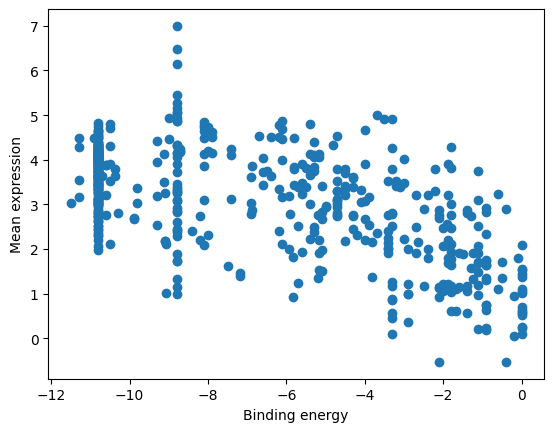

In [16]:
plt.scatter(df["Binding energy"],df["Mean expression"])
plt.xlabel("Binding energy")
plt.ylabel("Mean expression");

The most frequently occurring Shine-Dalgarno sequence appears to be `UAAGGAGG`. This is consistent with [existing literature](https://doi.org/10.1073/pnas.71.4.1342).

In [17]:
df["Shine-Dalgarno"].mode()

0    UAAGGAGG
Name: Shine-Dalgarno, dtype: object

We can see that spacings close to the optimum give rise to higher expressions, on average.

In [18]:
df.groupby("Spacing").mean(numeric_only=True)["Mean expression"].nlargest(3)

Spacing
6    3.447819
7    3.087722
8    3.077621
Name: Mean expression, dtype: float64

We can also see that extreme spacings give rise to lower expressions, on average.

In [19]:
df.groupby("Spacing").mean(numeric_only=True)["Mean expression"].nsmallest(3)

Spacing
11   -0.522879
2     0.617000
19    0.623249
Name: Mean expression, dtype: float64

However, when the spacing is optimum, other factors can still play a role in determining the overall translation efficiency. This can be seen from the range of expression levels even with optimal spacing.

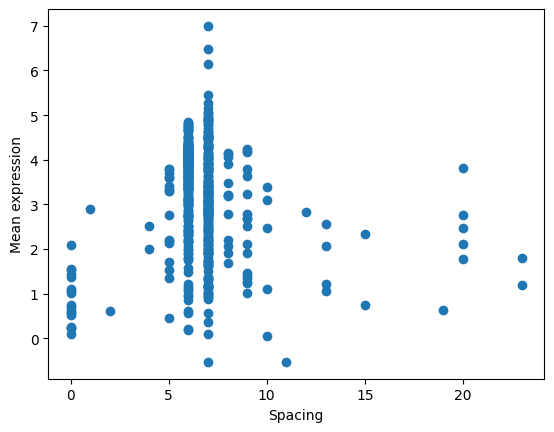

In [20]:
plt.scatter(df["Spacing"],df["Mean expression"])
plt.xlabel("Spacing")
plt.ylabel("Mean expression");

# Effect of S1 ribosomal protein

[Komarova et al. (2005)](https://doi.org/10.1128/jb.187.4.1344-1349.2005) found that the S1 protein present in the ribosome's 30S subunit interacts with A/U-rich sequences upstream of the Shine-Dalgarno site. This interaction is believed to protect the mRNA from degradation by RNAses, which also use A/U-rich sequences as recognition sites. The insertion of A/U-rich elements upstream of the Shine-Dalgarno sequence enhances translation efficiency.

X-ray crystallographic studies by [Sengupta et al. (2001)](https://doi.org/10.1073%2Fpnas.211266898) found that the S1 protein interacts with 11 nucleotides upstream of the Shine-Dalgarno sequence.

To quantify this interaction, we simply calculate the number of adenine and uracil nucleotides in the mRNA's putative region of interaction with the S1 protein.

In [21]:
def find_au_score(rbs,sd):

    sd_loc = rbs.index(sd)
    upstream = rbs[sd_loc-11 : sd_loc]

    au_score = upstream.count("A") + upstream.count("U")

    if len(upstream) == 0:
      return 0
    else:
      return au_score / len(upstream)

In [22]:
find_au_score = np.vectorize(find_au_score)

In [23]:
df["AU score"] = find_au_score(df["RBS"],df["Shine-Dalgarno"])

We can see that mRNAs with higher A/U scores tend to have higher expression levels, on average.

In [24]:
df.groupby("AU score").mean(numeric_only=True)["Mean expression"].nlargest(3)

AU score
1.000000    4.114012
0.909091    3.788629
0.727273    3.723766
Name: Mean expression, dtype: float64

In [25]:
df.groupby("AU score").mean(numeric_only=True)["Mean expression"].nsmallest(3)

AU score
0.000000    2.513312
0.545455    2.612632
0.636364    2.788639
Name: Mean expression, dtype: float64

# Regional folding of the mRNA

The region of the mRNA containing the RBS can transiently fold and unfold. The ribosome can only bind to the RBS if it is accessible. This means that the region surrounding the RBS should be free of secondary structures, or if secondary structures are present, they should be easily removable (i.e., lesser work required to unfold them).

[Hüttenhofer and Noller (1994)](https://doi.org/10.1002%2Fj.1460-2075.1994.tb06700.x) found that the 30S subunit interacts with 54-57 nucleotides of the mRNA. We will consider this region, centered around the start codon, while determining its accessibility. We crudely quantify the accessibility by considering the number of paired and unpaired nucleotides in the secondary structure of the region under consideration.

In [26]:
def find_accessibility_score(rbs,cds,sd,temp):

  RNA.cvar.temperature = temp

  sd_loc = rbs.index(sd)

  upstream = rbs[-27:]
  downstream = cds[:54-len(upstream)]

  structure, fold_energy = RNA.fold(upstream + downstream)

  loop_count = structure.count(".")                                               # Number of unpaired nucleotides
  stack_count = structure.count("(") + structure.count(")")                       # Number of paired nucleotides

  accessibility_score = loop_count / (loop_count + stack_count)

  return structure, accessibility_score, fold_energy

In [27]:
find_accessibility_score = np.vectorize(find_accessibility_score)

In [28]:
df["Structure"], df["Accessibility score"], df["Folding energy"] = find_accessibility_score(df["RBS"],df["CDS"],df["Shine-Dalgarno"],df["Temperature"])

We can see that a higher accessibility score leads to higher expression levels, on average.

In [29]:
df[df["Accessibility score"] <= df["Accessibility score"].describe()["25%"]].mean(numeric_only=True)["Mean expression"]

2.4485686844042025

In [30]:
df[df["Accessibility score"] >= df["Accessibility score"].describe()["75%"]].mean(numeric_only=True)["Mean expression"]

3.8523290805380643

We can also see that having a higher folding energy (i.e., lesser work required for unfolding) also leads to higher expression levels.

In [31]:
np.corrcoef(df["Mean expression"],df["Folding energy"])[0][1]

0.5840578740444917

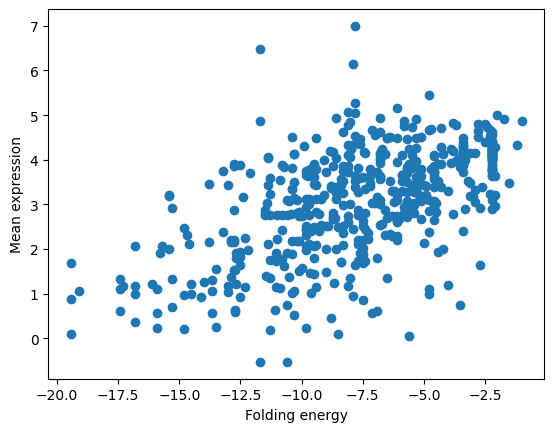

In [32]:
plt.scatter(df["Folding energy"],df["Mean expression"])
plt.xlabel("Folding energy")
plt.ylabel("Mean expression");

# Standby sites

If the RBS is transiently folded, the ribosome may bind to standby sites upstream of the Shine-Dalgarno sequence (See: [de Smit and van Duin (2003)](https://doi.org/10.1016/S0022-2836(03)00809-X)). This site has to be easily accessible to the ribosome. Thus, it should have minimal secondary structure formation.

In [33]:
def find_standby_score(rbs,structure):

  upstream = rbs[-27:]
  upstream_structure = structure[-27:]
  rRNA_length = 8

  if len(upstream_structure) != 0:

    upstream = upstream[::-1]
    upstream_structure = upstream_structure[::-1]

    best_gap = 0
    best_accessibility = 0

    for i in range(len(upstream)-rRNA_length+1):

      gap = i+rRNA_length
      loop_count = upstream_structure[i:i+rRNA_length].count(".")
      stack_count = upstream_structure[i:i+rRNA_length].count("(") + upstream_structure[i:i+rRNA_length].count(")")
      accessibility = loop_count / (loop_count + stack_count)

      if accessibility > best_accessibility:
        best_gap = gap
        best_accessibility = accessibility

    return best_gap, best_accessibility

  else:

    return 0,0

In [34]:
find_standby_score = np.vectorize(find_standby_score)

In [35]:
df["Standby gap"], df["Standby accessibility"] = find_standby_score(df["RBS"],df["Structure"])

We can see that more accessible standby sites have a higher expression level than less accessible standby sites.

In [36]:
df[df["Standby accessibility"] <= df["Standby accessibility"].describe()["25%"]].mean(numeric_only=True)["Mean expression"]

2.6358491825677226

In [37]:
df[df["Standby accessibility"] >= df["Standby accessibility"].describe()["75%"]].mean(numeric_only=True)["Mean expression"]

3.3233743435765963

# Effect of start codon

The start codon in the coding sequence can also influence translation efficiency. [Hecht et al. (2017)](https://doi.org/10.1093%2Fnar%2Fgkx070) characterized the strengths of the 64 possible start codons. Using their experimental data, we develop a scoring system for the different start codons.

In [38]:
codon_scores = {"AGC":0,"CCG":0.78,"CAG":0.95,"UGC":1.01,"CUC":1.1,"UCC":1.1,"CCC":1.17,"UAG":1.19,"CGG":1.2,"CUU":1.21,"CCU":1.26,"UUC":1.29,"CCA":1.3,"UAC":1.3,"CGC":1.31,"UCU":1.32,"ACC":1.32,"ACA":1.33,"CGU":1.33,"GCC":1.33,"CUA":1.34,"AAC":1.37,"CAC":1.41,"UCA":1.41,"AAA":1.43,"GCU":1.45,"AGU":1.46,"UAA":1.47,"GGC":1.48,"AGA":1.51,"UUU":1.54,"GAC":1.54,"AAG":1.56,"ACU":1.56,"UGA":1.56,"UGU":1.59,"CAA":1.59,"GUC":1.61,"GCA":1.64,"UGG":1.66,"CGA":1.69,"AGG":1.71,"GGA":1.71,"GGU":1.71,"GAG":1.72,"UUA":1.72,"UCG":1.78,"GGG":1.79,"GCG":1.84,"ACG":1.88,"GAU":1.92,"AAU":1.93,"GAA":2.02,"GUU":2.1,"GUA":2.11,"UAU":2.16,"CAU":2.17,"AUC":2.41,"AUU":2.57,"CUG":2.63,"AUA":2.73,"UUG":4.18,"GUG":4.22,"AUG":4.3}

In [39]:
def find_codon_score(cds):

  codon = cds[:3]
  codon_score = codon_scores[codon]

  return codon_score

In [40]:
df["Codon score"] = df["CDS"].apply(find_codon_score)

We can see that when the codon score is lesser than 4, the expression level reduces.

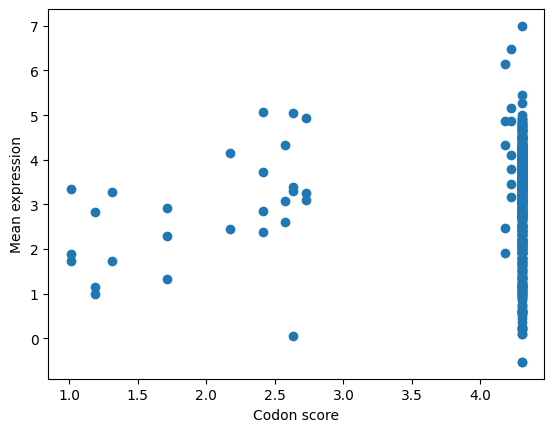

In [41]:
plt.scatter(df["Codon score"],df["Mean expression"])
plt.xlabel("Codon score")
plt.ylabel("Mean expression");

We have now completed the necessary feature engineering for the dataset. We can now train our model.

# Model training

First, we split the data into features and labels.

In [42]:
X = df[["Binding energy","Spacing","AU score","Accessibility score","Folding energy","Standby gap","Standby accessibility","Codon score"]]
y = df["Mean expression"]

Then, we split the data into a training test and a test set.

In [43]:
from sklearn.model_selection import train_test_split

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

We can then train our model.

In [45]:
from sklearn.ensemble import RandomForestRegressor

In [46]:
model = RandomForestRegressor(n_estimators=100, random_state=23)
model.fit(X_train,y_train)

RandomForestRegressor(random_state=23)

We can validate the fitted model on the test set.

In [47]:
predictions = model.predict(X_test)
np.corrcoef(y_test,predictions)[0][1]

0.7923960814760643

We can test the model on the whole dataset now.

In [48]:
predictions = model.predict(X)
np.corrcoef(y,predictions)[0][1]

0.9203675134197622

This is excellent performance for a model that hasn't had its hyperparameters tuned!

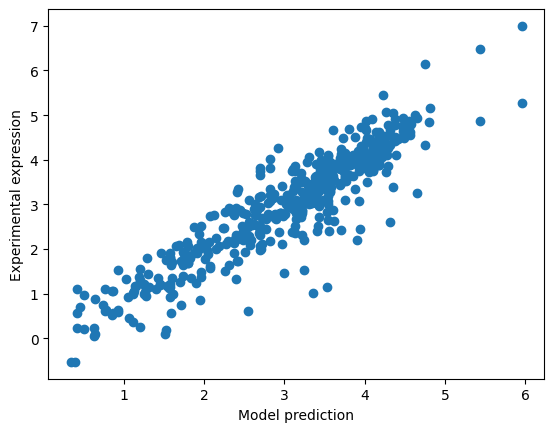

In [49]:
plt.scatter(predictions,y)
plt.xlabel("Model prediction")
plt.ylabel("Experimental expression");

We can also examine the features that the model deemed were important.

In [50]:
for i in range(len(X.columns)):
  print(f"{model.feature_importances_[i]} - {X.columns[i]}")

0.5097181017016925 - Binding energy
0.035906817262025804 - Spacing
0.07165546235204988 - AU score
0.05983490630997592 - Accessibility score
0.22156736557834925 - Folding energy
0.03592891281625742 - Standby gap
0.017482524179110046 - Standby accessibility
0.04790590980053921 - Codon score


`Binding energy` and `Folding energy` seem to be the most important factors while determining the expression level.

To get the best out of our model, we will retrain it on the whole dataset.

In [51]:
model.fit(X,y);

We can now test it on another dataset to get a true measure of its performance.

# Dataset for model testing

We use a dataset of 1014 mRNA sequences from [Reis and Salis (2020)](https://doi.org/10.1021/acssynbio.0c00394) to test our model. This dataset includes sequences from the training dataset, as well as new sequences.

In [52]:
test_df = pd.read_csv("/Dataset - Reis and Salis - 1014.csv")

In [53]:
test_df.head()

,Reference,Reporter,Bacterial species,Gram stain,Temperature,rRNA,RBS,CDS,Mean expression
0,EspahBorujeni_NAR_2013,RFP,Escherichia coli str. K-12 substr. DH10B,Negative,37,ACCTCCTTA,TCTAGAGGCCGACGCAAGCCCATATCGGGGCTTCCGTCGGCCATAA...,ATGgcGAGCTCtgaagacgttatcaaagagttcatgcgtttcaaag...,279.362222
1,EspahBorujeni_NAR_2013,RFP,Escherichia coli str. K-12 substr. DH10B,Negative,37,ACCTCCTTA,TCTAGAGGCCGACGCAAGCCCATATCGGGGCTTCCGTCGGCCAATA...,ATGgcGAGCTCtgaagacgttatcaaagagttcatgcgtttcaaag...,700.137712
2,EspahBorujeni_NAR_2013,RFP,Escherichia coli str. K-12 substr. DH10B,Negative,37,ACCTCCTTA,TCTAGAGGCCGACGCAAGCCCATATCGGGGCTTCCGTCGGCCAAAT...,ATGgcGAGCTCtgaagacgttatcaaagagttcatgcgtttcaaag...,958.882321
3,EspahBorujeni_NAR_2013,RFP,Escherichia coli str. K-12 substr. DH10B,Negative,37,ACCTCCTTA,TCTAGAGGCCGACGCAAGCCCATATCGGGGCTTCCGTCGGCCAAAA...,ATGgcGAGCTCtgaagacgttatcaaagagttcatgcgtttcaaag...,3037.856308
4,EspahBorujeni_NAR_2013,RFP,Escherichia coli str. K-12 substr. DH10B,Negative,37,ACCTCCTTA,TCTAGAGGCCGACGCAAGCCCATATCGGGGCTTCCGTCGGCCAAAA...,ATGgcGAGCTCtgaagacgttatcaaagagttcatgcgtttcaaag...,8127.452151


We perform the same preprocessing tasks as we did with the training dataset.

In [54]:
test_df["rRNA"] = test_df["rRNA"].apply(lambda x: x.upper().replace("T","U"))
test_df["RBS"] = test_df["RBS"].apply(lambda x: x.upper().replace("T","U"))
test_df["CDS"] = test_df["CDS"].apply(lambda x: x.upper().replace("T","U"))
test_df["rRNA"] = test_df["rRNA"].apply(lambda x: x[-8:])
test_df["Mean expression"] = test_df["Mean expression"].apply(lambda x: np.log10(x))

We calculate the necessary parameters for our model to use and predict expression levels

In [55]:
test_df["Binding energy"], test_df["Shine-Dalgarno"], test_df["Spacing"] = find_spacing(test_df["rRNA"],test_df["RBS"],test_df["Temperature"],test_df["Gram stain"])
test_df["AU score"] = find_au_score(test_df["RBS"],test_df["Shine-Dalgarno"])
test_df["Structure"], test_df["Accessibility score"], test_df["Folding energy"] = find_accessibility_score(test_df["RBS"],test_df["CDS"],test_df["Shine-Dalgarno"],test_df["Temperature"])
test_df["Standby gap"], test_df["Standby accessibility"] = find_standby_score(test_df["RBS"],test_df["Structure"])
test_df["Codon score"] = test_df["CDS"].apply(find_codon_score)

We can then test our model on this dataset.

In [56]:
test_X = test_df[["Binding energy","Spacing","AU score","Accessibility score","Folding energy","Standby gap","Standby accessibility","Codon score"]]
test_y = test_df["Mean expression"]

In [57]:
test_predictions = model.predict(test_X)
np.corrcoef(test_y,test_predictions)[0][1]

0.7883381275985868

Our model's predictions achieve a very good correlation with the experimental data.

[Reis and Salis (2020)](https://doi.org/10.1021/acssynbio.0c00394) compared the performance of existing models on this dataset. The best performer was their own [RBS Calculator v2.1](https://salislab.net/software/predict_rbs_calculator), which achieved an R² of 0.76.

Finally, we retrain our model on the entire dataset of 1014 sequences to boost its performance.

In [58]:
model.fit(test_X,test_y)
test_predictions = model.predict(test_X)
np.corrcoef(test_y,test_predictions)[0][1]

0.9557595432371457

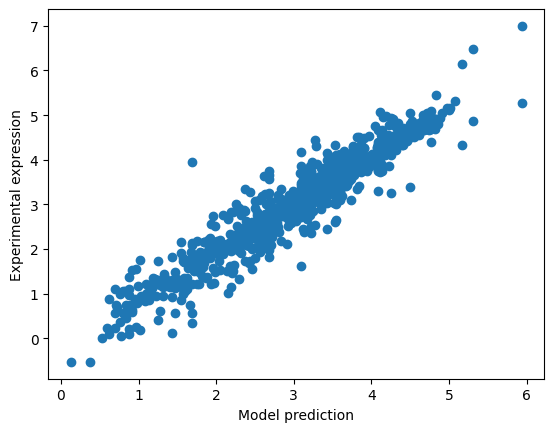

In [59]:
plt.scatter(test_predictions,test_y)
plt.xlabel("Model prediction")
plt.ylabel("Experimental expression");

With that, we have a working model to predict the expression level of a given mRNA sequence!

# Further testing

We will test our model on a dataset of 16779 mRNA sequences (from [Reis and Salis (2020)](https://doi.org/10.1021/acssynbio.0c00394)) characterized by FlowSeq. The RBS Calculator achieves an R² of 0.17 on this dataset.

In [60]:
flowseq = pd.read_csv("/Dataset - Reis and Salis - 16779.csv")

In [61]:
len(flowseq)

16779

In [62]:
flowseq["rRNA"] = flowseq["rRNA"].apply(lambda x: x.upper().replace("T","U"))
flowseq["RBS"] = flowseq["RBS"].apply(lambda x: x.upper().replace("T","U"))
flowseq["CDS"] = flowseq["CDS"].apply(lambda x: x.upper().replace("T","U"))
flowseq["rRNA"] = flowseq["rRNA"].apply(lambda x: x[-8:])
flowseq["Mean expression"] = flowseq["Mean expression"].apply(lambda x: np.log10(x))

In [63]:
flowseq["Binding energy"], flowseq["Shine-Dalgarno"], flowseq["Spacing"] = find_spacing(flowseq["rRNA"],flowseq["RBS"],flowseq["Temperature"],flowseq["Gram stain"])
flowseq["AU score"] = find_au_score(flowseq["RBS"],flowseq["Shine-Dalgarno"])
flowseq["Structure"], flowseq["Accessibility score"], flowseq["Folding energy"] = find_accessibility_score(flowseq["RBS"],flowseq["CDS"],flowseq["Shine-Dalgarno"],flowseq["Temperature"])
flowseq["Standby gap"], flowseq["Standby accessibility"] = find_standby_score(flowseq["RBS"],flowseq["Structure"])
flowseq["Codon score"] = flowseq["CDS"].apply(find_codon_score)

In [64]:
X = flowseq[["Binding energy","Spacing","AU score","Accessibility score","Folding energy","Standby gap","Standby accessibility","Codon score"]]
y = flowseq["Mean expression"]
p = model.predict(X)
np.corrcoef(y,p)[0][1]

0.5372845355864897